## Imports

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

# **Variational Autoencoder**

## **VAE Implementation**
In this class, we implement Variational Autoencoder.
This network has three layers for encoding and 3 layers for decoding that they are counter part of each other.

Encode part implemented as `encode` function. Output of this layer is two dimension for each of $\mu$ and logvar.

Decode part implemented as `encode` function.

Forward function gathered them. At first, run encode part. After that it reparametrized it to make it possible to back propagate. It's implemented in `reparameterize` funciton. At the end, run decode part and output it with $\mu$ and logvar.

In [ ]:
class VAE(nn.Module):
  def __init__(self, image_channels=784, latent_dim=2):
    super(VAE, self).__init__()
    
    self.enc_fc_1 = nn.Linear(image_channels, 400)
    self.enc_fc_2 = nn.Linear(400, 200)
    self.enc_fc_3_mu = nn.Linear(200, latent_dim)
    self.enc_fc_3_logvar = nn.Linear(200, latent_dim)

    self.dec_fc_1 = nn.Linear(latent_dim, 200)
    self.dec_fc_2 = nn.Linear(200, 400)
    self.dec_fc_3 = nn.Linear(400, image_channels)

    self.activation_func = F.relu

  def encode(self, input):
    out = self.enc_fc_1(input)
    out = self.activation_func(out)
    out = self.enc_fc_2(out)
    out = self.activation_func(out)
    out_mu = self.enc_fc_3_mu(out)
    out_logvar = self.enc_fc_3_logvar(out)
    return out_mu, out_logvar

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

  def decode(self, input):
    out = self.dec_fc_1(input)
    out = self.activation_func(out)
    out = self.dec_fc_2(out)
    out = self.activation_func(out)
    out = self.dec_fc_3(out)
    out = torch.sigmoid(out)
    return out

  def forward(self, input):
    mu, logvar = self.encode(input)
    z = self.reparameterize(mu, logvar)
    return self.decode(z), mu, logvar

## Loss funciton
It's combination of Binary class entropy with KL Divergence. Full explanation of this functions come in report.

In [ ]:
def loss_function(reconstruction_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(reconstruction_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

## Train
For training, We input features to model and get output. Then calculate loss function and back propagate it. We append losses to an array. 

We do it for some of outputs to generate some middle results to see model progress.

`evaluate_VAE` run model on some data and plot it's output.

In [ ]:
def train_VAE(model, train_loader, epochs_num, optimizer):
  epochs_train_loss = []
  train_size = 0
  test_inputs, _ = next(iter(train_loader))  
  test_inputs = test_inputs.cuda().view(-1, 784)
  test_outputs = []

  for i, epoch in tqdm(enumerate(range(1, epochs_num+1))):
    batches_train_loss = []

    for index, data in enumerate(train_loader):
      features, targets = data
      train_size += len(features)
      features = features.float() 
      targets = targets.float()
      features, targets = features.cuda(), targets.cuda()
      optimizer.zero_grad()
      features = features.view(-1, 784)
      reconstruction_batch, mu, logvar = model(features)
      loss = loss_function(reconstruction_batch, features, mu, logvar)
      loss.backward()
      optimizer.step()
      batches_train_loss.append(loss.item())
    
    with torch.no_grad():
      test_output, _, _ = model(test_inputs)
      test_outputs.append(test_output)

    epochs_train_loss.append(np.sum(batches_train_loss)/train_size)
    print('Epoch {} is finished!'.format(epoch))
  return epochs_train_loss, test_outputs

In [ ]:
def evaluate_VAE(loader, model):
  all_targets = []
  latent_space = []
  all_outputs = []
  all_inputs = []
  with torch.no_grad():
    for features, target in loader:
      all_targets.append(np.array(target))
      features, target = features.cuda(), target.cuda()
      features = features.float() 
      target = target.float()
      features = features.view(-1, 784)
      out_mu,out_logvar = model.encode(features)
      out = model.reparameterize(out_mu, out_logvar)
      latent_space.append(out)
      out = model.decode(out)
      all_outputs.append(out)
      all_inputs.append(features)
  return all_targets, latent_space, all_outputs, all_inputs

## Plot Result
This funciton is for plotting losses against epoch number.

In [ ]:
def plot_result(epochs_train, epochs_num, title):
  x_axis = range(1, epochs_num+1)
  legends = ['train']
  x_label = 'Epoch'
  plt.plot(x_axis, epochs_train)
  plt.title(title)
  plt.xlabel(x_label)
  plt.legend(legends)
  plt.show()

This function is for plotting different classes distribution in latent space.

In [ ]:
def plot_latent_space(scatter_x, scatter_y, group):
  cdict = ['blue', 'red', 'green', 'yellow', 'pink', 'gray', 'black', 'orange', 'olive', 'purple']

  fig, ax = plt.subplots(figsize=(10,10))
  for g in np.unique(group):
      ix = np.where(group == g)
      ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 100)
  ax.legend()
  plt.show()

This funciton show some numbers images.


In [ ]:
def show_numbers(numbers):
  columns = 10
  rows = 10
  fig = plt.figure(figsize=(columns, rows))
  for i,number in enumerate(numbers):
    fig.add_subplot(rows, columns, i+1)
    number = number.reshape(28,28)
    plt.imshow(number, cmap="gray")
    plt.axis('off')

## Prepare Data
We get MNIST train set from torch datasets.

In [ ]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Run VAE
We run our model with `Adam` optimizer and small learning rate for 50 epochs.

In [ ]:
model_VAE = VAE()
model_VAE.cuda()
optimizer_VAE = optim.Adam(model_VAE.parameters(), lr=1e-3)

In [ ]:
epochs_train_loss_VAE, test_results = train_VAE(model_VAE, train_loader, 50, optimizer_VAE)

1it [00:06,  6.80s/it]

Epoch 1 is finished!


2it [00:13,  6.72s/it]

Epoch 2 is finished!


3it [00:19,  6.67s/it]

Epoch 3 is finished!


4it [00:26,  6.79s/it]

Epoch 4 is finished!


5it [00:34,  6.87s/it]

Epoch 5 is finished!


6it [00:41,  6.92s/it]

Epoch 6 is finished!


7it [00:47,  6.91s/it]

Epoch 7 is finished!


8it [00:54,  6.79s/it]

Epoch 8 is finished!


9it [01:00,  6.71s/it]

Epoch 9 is finished!


10it [01:07,  6.65s/it]

Epoch 10 is finished!


11it [01:13,  6.61s/it]

Epoch 11 is finished!


12it [01:20,  6.57s/it]

Epoch 12 is finished!


13it [01:27,  6.58s/it]

Epoch 13 is finished!


14it [01:34,  6.72s/it]

Epoch 14 is finished!


15it [01:41,  6.81s/it]

Epoch 15 is finished!


16it [01:48,  6.89s/it]

Epoch 16 is finished!


17it [01:54,  6.82s/it]

Epoch 17 is finished!


18it [02:01,  6.74s/it]

Epoch 18 is finished!


19it [02:07,  6.68s/it]

Epoch 19 is finished!


20it [02:14,  6.63s/it]

Epoch 20 is finished!


21it [02:20,  6.59s/it]

Epoch 21 is finished!


22it [02:27,  6.56s/it]

Epoch 22 is finished!


23it [02:34,  6.60s/it]

Epoch 23 is finished!


24it [02:41,  6.73s/it]

Epoch 24 is finished!


25it [02:48,  6.81s/it]

Epoch 25 is finished!


26it [02:55,  6.87s/it]

Epoch 26 is finished!


27it [03:01,  6.80s/it]

Epoch 27 is finished!


28it [03:08,  6.81s/it]

Epoch 28 is finished!


29it [03:15,  6.88s/it]

Epoch 29 is finished!


30it [03:22,  6.93s/it]

Epoch 30 is finished!


31it [03:29,  6.97s/it]

Epoch 31 is finished!


32it [03:36,  6.82s/it]

Epoch 32 is finished!


33it [03:42,  6.73s/it]

Epoch 33 is finished!


34it [03:49,  6.68s/it]

Epoch 34 is finished!


35it [03:55,  6.62s/it]

Epoch 35 is finished!


36it [04:02,  6.59s/it]

Epoch 36 is finished!


37it [04:08,  6.56s/it]

Epoch 37 is finished!


38it [04:15,  6.69s/it]

Epoch 38 is finished!


39it [04:22,  6.83s/it]

Epoch 39 is finished!


40it [04:30,  6.89s/it]

Epoch 40 is finished!


41it [04:37,  6.94s/it]

Epoch 41 is finished!


42it [04:43,  6.85s/it]

Epoch 42 is finished!


43it [04:50,  6.75s/it]

Epoch 43 is finished!


44it [04:56,  6.69s/it]

Epoch 44 is finished!


45it [05:03,  6.64s/it]

Epoch 45 is finished!


46it [05:09,  6.60s/it]

Epoch 46 is finished!


47it [05:16,  6.58s/it]

Epoch 47 is finished!


48it [05:23,  6.71s/it]

Epoch 48 is finished!


49it [05:30,  6.80s/it]

Epoch 49 is finished!


50it [05:37,  6.75s/it]

Epoch 50 is finished!


At the end of training, We plot some of digits in different epochs to see progress of model learning.

In [ ]:
test_results_VAE = np.array([np.array(j.cpu()) for i in test_results for j in i])

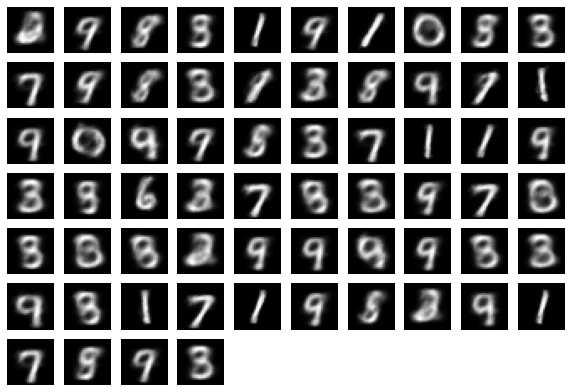

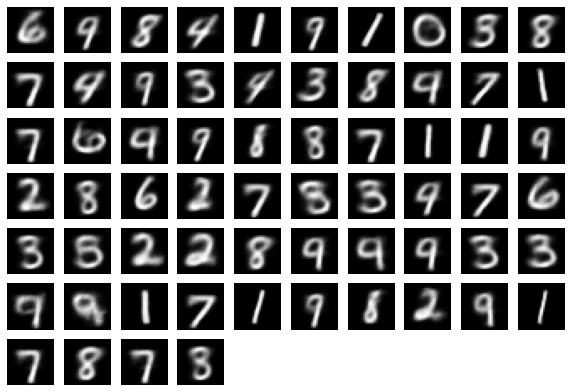

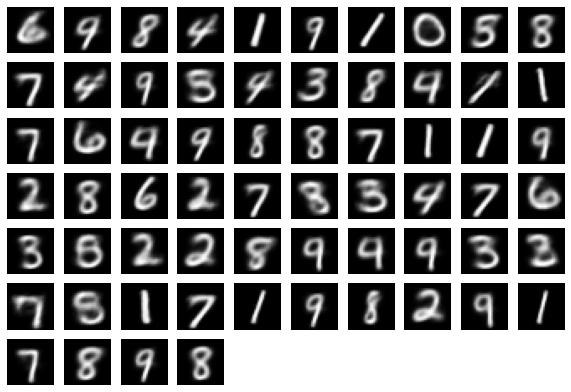

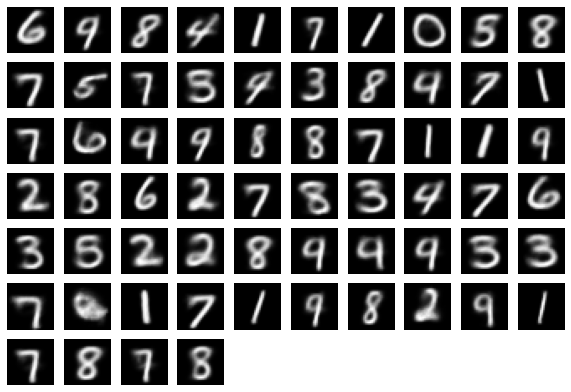

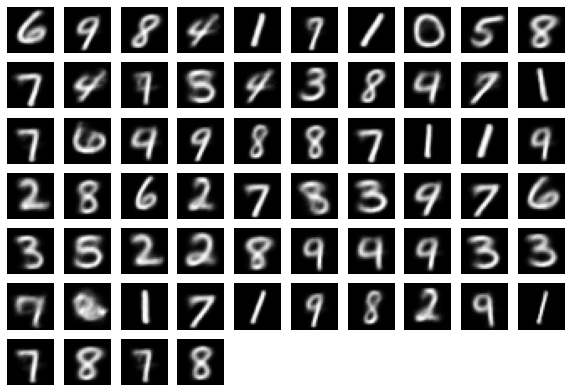

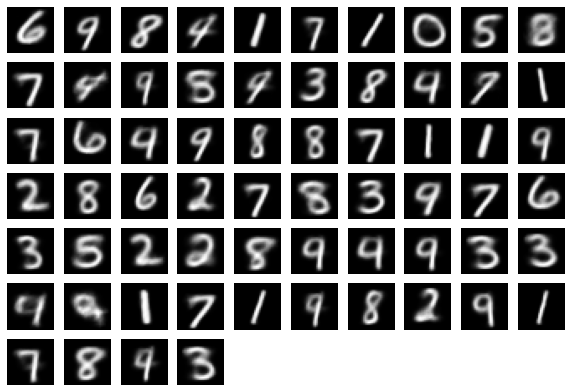

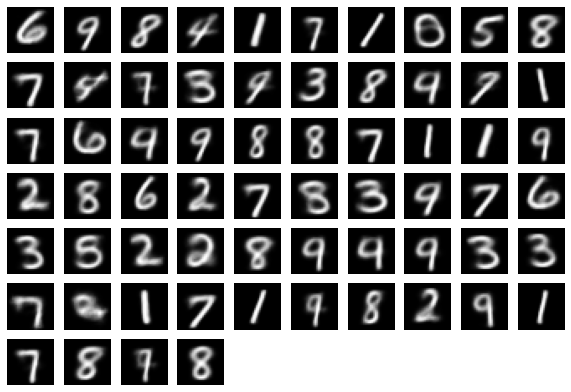

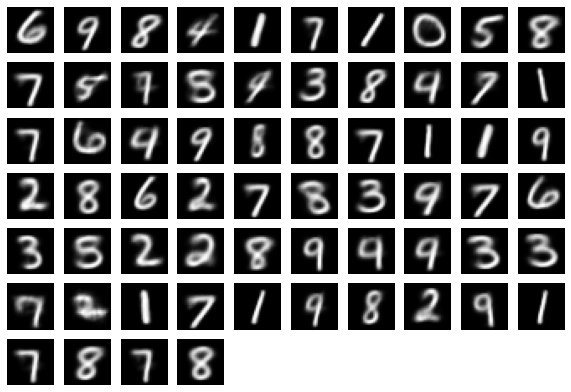

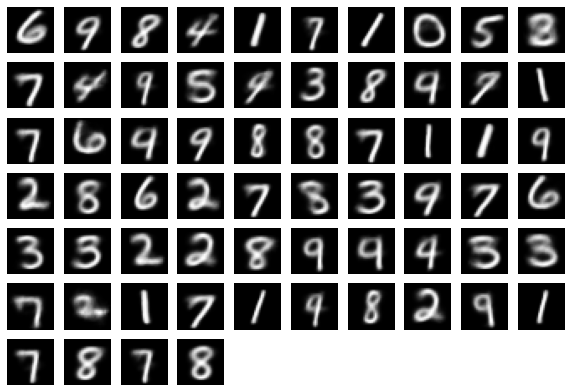

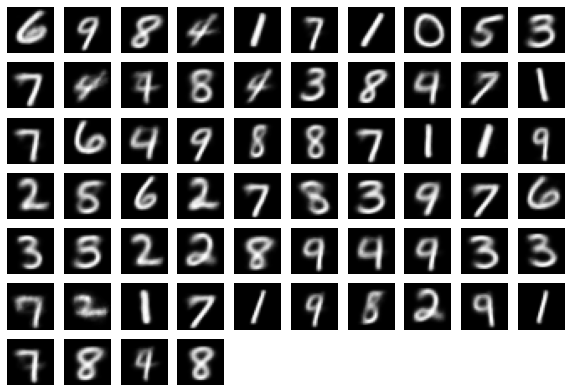

In [ ]:
for epoch in np.arange(50, step=5):
  epoch_res = test_results_VAE[epoch*64:epoch*64+64]
  show_numbers(epoch_res)

And plotting loss in different epochs and it's good progress.

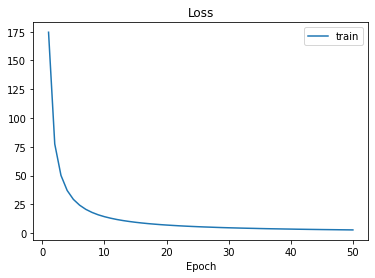

In [ ]:
plot_result(epochs_train_loss_VAE, 50, "Loss")

## Analyze Latent Space
We plot data distribution of different classes to examine distribution and relation of different classes.

In [ ]:
targets_VAE, latent_space_VAE, model_outputs_VAE, model_inputs_VAE = evaluate_VAE(train_loader, model_VAE)

In [ ]:
targets_VAE = np.array([j for i in targets_VAE for j in i])
latent_space_VAE = np.array([np.array(j.cpu()) for i in latent_space_VAE for j in i])

In [ ]:
model_outputs_VAE = np.array([np.array(j.cpu()) for i in model_outputs_VAE for j in i])
model_inputs_VAE = np.array([np.array(j.cpu()) for i in model_inputs_VAE for j in i])

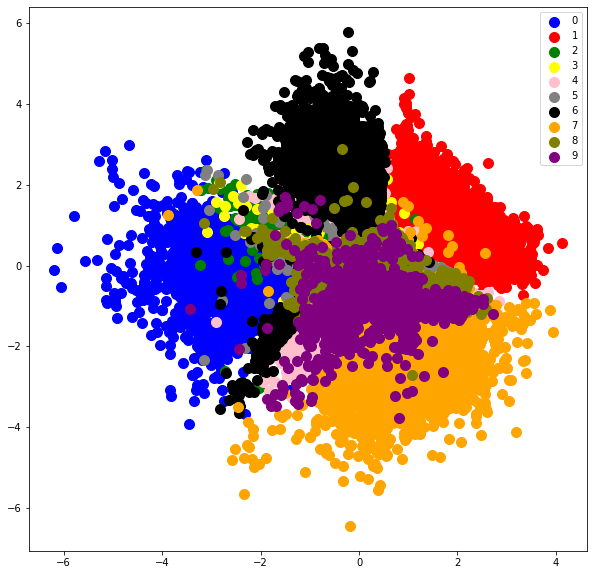

In [ ]:
plot_latent_space(latent_space_VAE.T[0], latent_space_VAE.T[1], targets_VAE)

In this part, we calculate min and max of each dimension of latent space. And generate some middle points in this two dimensions of latent space.

After that, we plot this points to see this range change of digits feature in latent space.

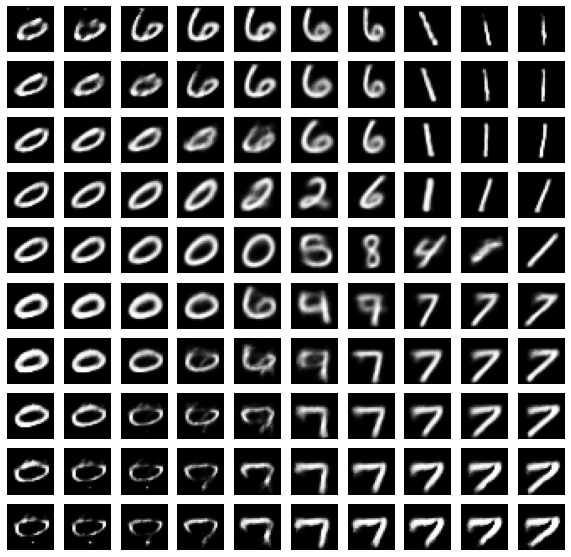

In [ ]:
min_x = latent_space_VAE.T[0].min()
max_x = latent_space_VAE.T[0].max()

min_y = latent_space_VAE.T[1].min()
max_y = latent_space_VAE.T[1].max()

x = np.arange(min_x, max_x, (max_x-min_x)/10)

y = np.arange(min_y, max_y, (max_y-min_y)/10)[::-1]

inp = []
for j in y:
  for i in x:
    inp.append(np.array([i, j]))
inp = torch.from_numpy(np.array(inp)).float().cuda()

out = model_VAE.decode(inp)
show_numbers(out.cpu().data.numpy())

## Analyze VAE Output
We generate some random indices for inputing to VAE. Then input this data to model and get output of model and plot it.

In [ ]:
random_index_VAE = np.random.choice(model_inputs_VAE.shape[0], 50, replace=False)  

In [ ]:
random_targets_VAE = targets_VAE[random_index_VAE]
random_inputs_VAE = model_inputs_VAE[random_index_VAE]
random_outputs_VAE = model_outputs_VAE[random_index_VAE]

In [ ]:
random_targets_VAE

array([4, 2, 5, 1, 3, 7, 5, 1, 3, 5, 8, 7, 5, 3, 3, 8, 5, 5, 8, 8, 8, 9,
       9, 1, 4, 1, 6, 0, 6, 8, 6, 8, 4, 6, 1, 9, 6, 5, 0, 8, 6, 8, 3, 0,
       2, 9, 7, 2, 0, 2])

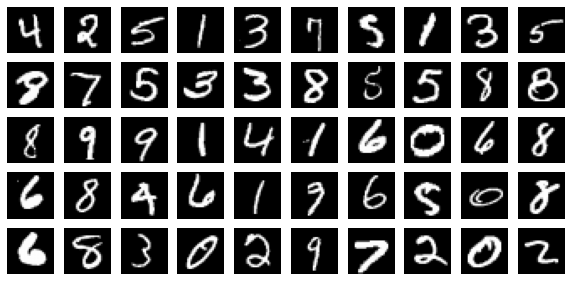

In [ ]:
show_numbers(random_inputs_VAE)

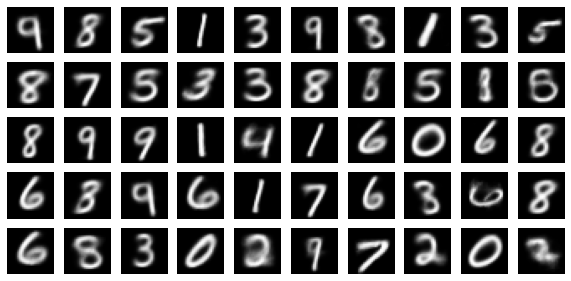

In [ ]:
show_numbers(random_outputs_VAE)

# **Conditional Variational Autoencoder**

## CVAE Implementation
In this class, we implement Conditional Variational Autoencoder.
Architecture of this network is similiar to `VAE` network.

Only difference is getting condition in encode and decode function. This functions concat this condition to input and then enter it to the pipeline.

In [ ]:
class CVAE(nn.Module):
  def __init__(self, image_channels=784, latent_dim=2):
    super(CVAE, self).__init__()
    
    self.enc_fc_1 = nn.Linear(image_channels+10, 400)
    self.enc_fc_2 = nn.Linear(400, 200)
    self.enc_fc_3_mu = nn.Linear(200, latent_dim)
    self.enc_fc_3_logvar = nn.Linear(200, latent_dim)

    self.dec_fc_1 = nn.Linear(latent_dim+10, 200)
    self.dec_fc_2 = nn.Linear(200, 400)
    self.dec_fc_3 = nn.Linear(400, image_channels)

    self.activation_func = F.relu

  def encode(self, input, cond):
    x = torch.cat([input, cond], 1)
    out = self.enc_fc_1(x)
    out = self.activation_func(out)
    out = self.enc_fc_2(out)
    out = self.activation_func(out)
    out_mu = self.enc_fc_3_mu(out)
    out_logvar = self.enc_fc_3_logvar(out)
    return out_mu,out_logvar

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

  def decode(self, input, cond):
    x = torch.cat([input, cond], 1)
    out = self.dec_fc_1(x)
    out = self.activation_func(out)
    out = self.dec_fc_2(out)
    out = self.activation_func(out)
    out = self.dec_fc_3(out)
    out = torch.sigmoid(out)
    return out

  def forward(self, input, cond):
    mu, logvar = self.encode(input, cond)
    z = self.reparameterize(mu, logvar)
    return self.decode(z, cond), mu, logvar

## Train and Test
This is similiar to vae training. The only difference is one hot encoding labels to enter them as condition.

After that, input them as condition to model and get desired output.

In [ ]:
def train_CVAE(model, train_loader, epochs_num, optimizer):
  epochs_train_loss = []
  train_size = 0
  test_inputs, test_targets = next(iter(train_loader))  
  test_targets = one_hot(test_targets, 10).float().cuda()
  test_inputs = test_inputs.cuda().view(-1, 784)
  test_outputs = []

  for i, epoch in tqdm(enumerate(range(1, epochs_num+1))):
    batches_train_loss = []

    for index, data in enumerate(train_loader):
      features, targets = data
      train_size += len(features)
      features = features.float() 
      # targets = targets.float()
      targets = one_hot(targets, 10).float()
      features, targets = features.cuda(), targets.cuda()
      optimizer.zero_grad()
      features = features.view(-1, 784)
      reconstruction_batch, mu, logvar = model(features, targets)
      loss = loss_function(reconstruction_batch, features, mu, logvar)
      loss.backward()
      optimizer.step()

      batches_train_loss.append(loss.item())

    with torch.no_grad():
      test_output, _, _ = model(test_inputs, test_targets)
      test_outputs.append(test_output)
    
    epochs_train_loss.append(np.sum(batches_train_loss)/train_size)
    print('Epoch {} is finished!'.format(epoch))
  return epochs_train_loss, test_outputs

This is the same with same difference that explained in previous parts...

In [ ]:
def evaluate_CVAE(loader, model):
  all_targets = []
  latent_space = []
  all_outputs = []
  all_inputs = []
  with torch.no_grad():
    for features, target in loader:
      all_targets.append(np.array(target))
      features = features.float()
      target = one_hot(target, 10)
      features, target = features.cuda(), target.cuda() 
      # target = target.float()
      features = features.view(-1, 784)
      out_mu, out_logvar = model.encode(features, target)
      out = model.reparameterize(out_mu, out_logvar)
      latent_space.append(out)
      out = model.decode(out, target)
      all_outputs.append(out)
      all_inputs.append(features)
  return all_targets, latent_space, all_outputs, all_inputs

## Run CVAE

We run our model and train it for 50 epochs.

In [ ]:
model_CVAE = CVAE()
model_CVAE.cuda()
optimizer_CVAE = optim.Adam(model_CVAE.parameters(), lr=1e-3)

This funciton one hot encode labels with respect to class count.

In [ ]:
def one_hot(labels, class_size):
  targets = torch.zeros(labels.size(0), class_size)
  for i, label in enumerate(labels):
      targets[i, label] = 1
  return targets

In [ ]:
epochs_train_loss_CVAE, test_results = train_CVAE(model_CVAE, train_loader, 50, optimizer_CVAE)

1it [00:06,  7.00s/it]

Epoch 1 is finished!


2it [00:13,  6.98s/it]

Epoch 2 is finished!


3it [00:20,  6.99s/it]

Epoch 3 is finished!


4it [00:27,  6.98s/it]

Epoch 4 is finished!


5it [00:35,  7.05s/it]

Epoch 5 is finished!


6it [00:42,  7.19s/it]

Epoch 6 is finished!


7it [00:50,  7.28s/it]

Epoch 7 is finished!


8it [00:57,  7.32s/it]

Epoch 8 is finished!


9it [01:04,  7.20s/it]

Epoch 9 is finished!


10it [01:11,  7.13s/it]

Epoch 10 is finished!


11it [01:18,  7.07s/it]

Epoch 11 is finished!


12it [01:25,  7.03s/it]

Epoch 12 is finished!


13it [01:32,  7.00s/it]

Epoch 13 is finished!


14it [01:39,  7.02s/it]

Epoch 14 is finished!


15it [01:46,  7.17s/it]

Epoch 15 is finished!


16it [01:54,  7.27s/it]

Epoch 16 is finished!


17it [02:01,  7.33s/it]

Epoch 17 is finished!


18it [02:08,  7.24s/it]

Epoch 18 is finished!


19it [02:15,  7.15s/it]

Epoch 19 is finished!


20it [02:22,  7.12s/it]

Epoch 20 is finished!


21it [02:29,  7.06s/it]

Epoch 21 is finished!


22it [02:36,  7.01s/it]

Epoch 22 is finished!


23it [02:43,  6.98s/it]

Epoch 23 is finished!


24it [02:51,  7.15s/it]

Epoch 24 is finished!


25it [02:58,  7.24s/it]

Epoch 25 is finished!


26it [03:06,  7.32s/it]

Epoch 26 is finished!


27it [03:13,  7.29s/it]

Epoch 27 is finished!


28it [03:20,  7.18s/it]

Epoch 28 is finished!


29it [03:27,  7.12s/it]

Epoch 29 is finished!


30it [03:34,  7.07s/it]

Epoch 30 is finished!


31it [03:41,  7.02s/it]

Epoch 31 is finished!


32it [03:47,  6.99s/it]

Epoch 32 is finished!


33it [03:55,  7.10s/it]

Epoch 33 is finished!


34it [04:02,  7.20s/it]

Epoch 34 is finished!


35it [04:10,  7.28s/it]

Epoch 35 is finished!


36it [04:17,  7.29s/it]

Epoch 36 is finished!


37it [04:24,  7.25s/it]

Epoch 37 is finished!


38it [04:32,  7.36s/it]

Epoch 38 is finished!


39it [04:39,  7.41s/it]

Epoch 39 is finished!


40it [04:47,  7.44s/it]

Epoch 40 is finished!


41it [04:54,  7.38s/it]

Epoch 41 is finished!


42it [05:01,  7.27s/it]

Epoch 42 is finished!


43it [05:08,  7.19s/it]

Epoch 43 is finished!


44it [05:15,  7.11s/it]

Epoch 44 is finished!


45it [05:22,  7.07s/it]

Epoch 45 is finished!


46it [05:29,  7.05s/it]

Epoch 46 is finished!


47it [05:36,  7.19s/it]

Epoch 47 is finished!


48it [05:44,  7.28s/it]

Epoch 48 is finished!


49it [05:51,  7.35s/it]

Epoch 49 is finished!


50it [05:59,  7.18s/it]

Epoch 50 is finished!


Plotting loss against different epochs...

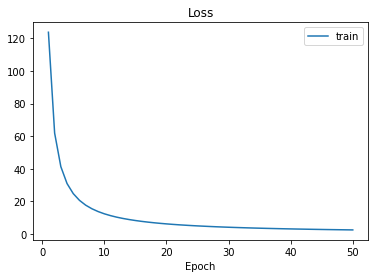

In [ ]:
plot_result(epochs_train_loss_CVAE, 50, "Loss")

Plotting results in different epochs to see progress of model learning...


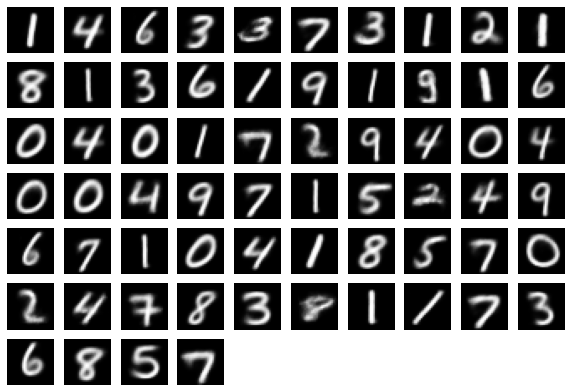

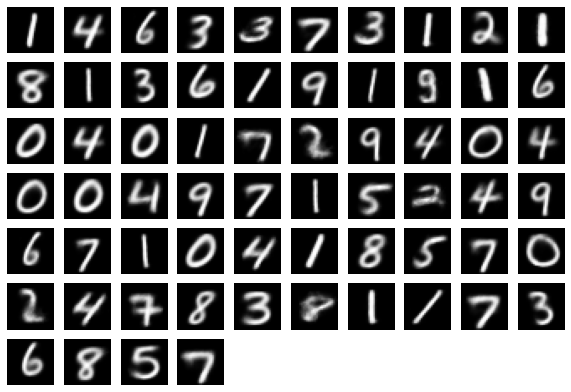

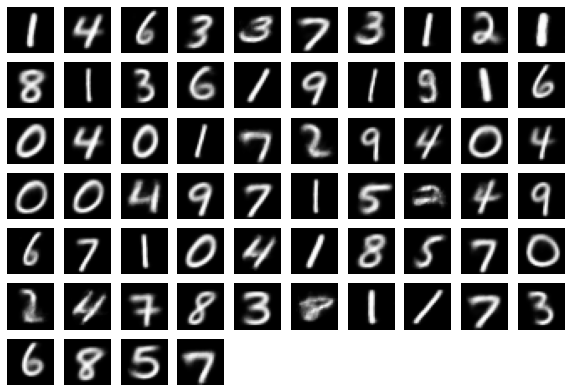

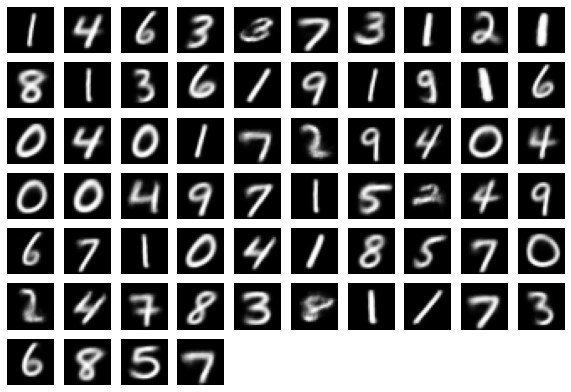

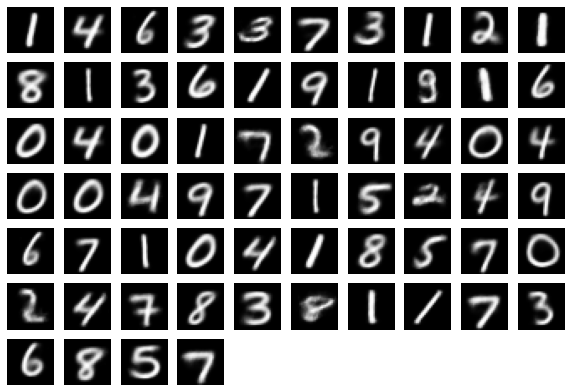

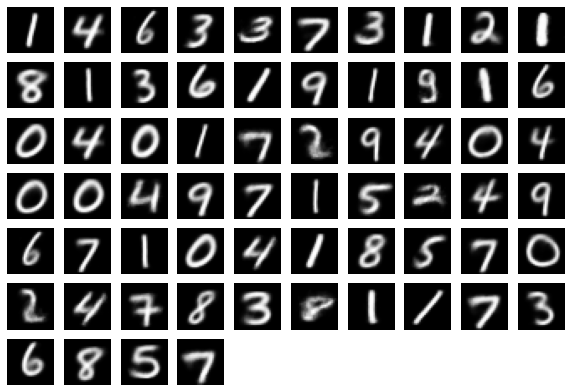

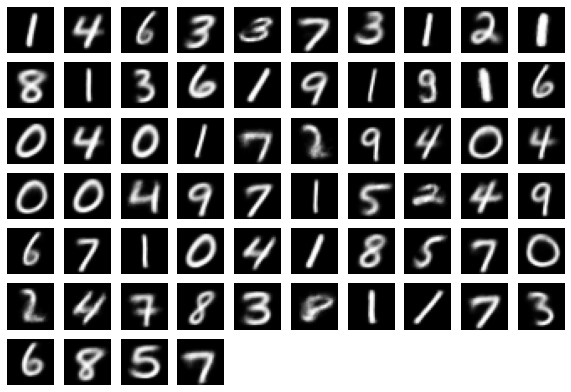

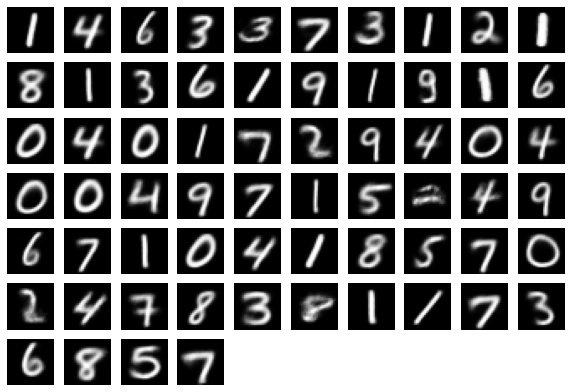

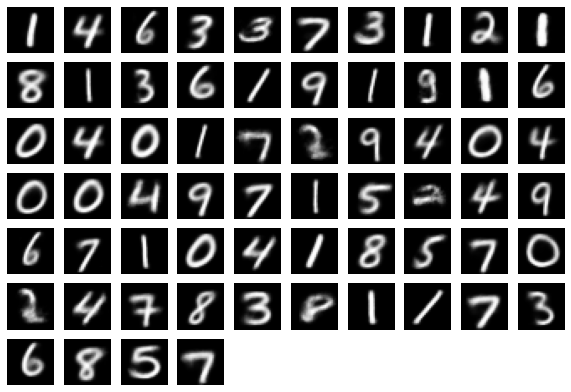

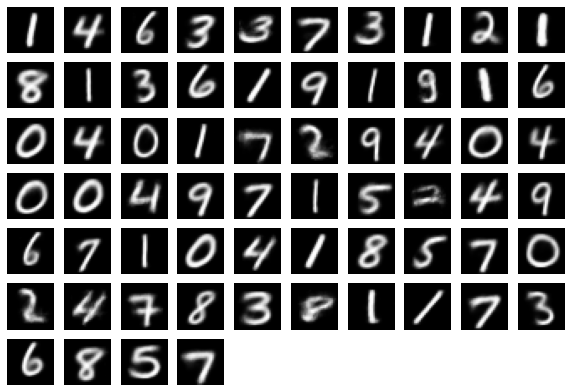

In [ ]:
test_results_CVAE = np.array([np.array(j.cpu()) for i in test_results for j in i])
for epoch in np.arange(50, step=5):
  epoch_res = test_results_CVAE[epoch*64:epoch*64+64]
  show_numbers(epoch_res)

## Analyze Latent Space
Here, we draw data distribution of different classes in latent space.

Generating new np arrays needed to make data compatible for drawing.

Different classes points have great intersection for generating good new data points.

In [ ]:
targets_CVAE, latent_space_CVAE, model_outputs_CVAE, model_inputs_CVAE = evaluate_CVAE(train_loader, model_CVAE)

In [ ]:
targets_CVAE = np.array([j for i in targets_CVAE for j in i])
latent_space_CVAE = np.array([np.array(j.cpu()) for i in latent_space_CVAE for j in i])

In [ ]:
model_outputs_CVAE = np.array([np.array(j.cpu()) for i in model_outputs_CVAE for j in i])
model_inputs_CVAE = np.array([np.array(j.cpu()) for i in model_inputs_CVAE for j in i])

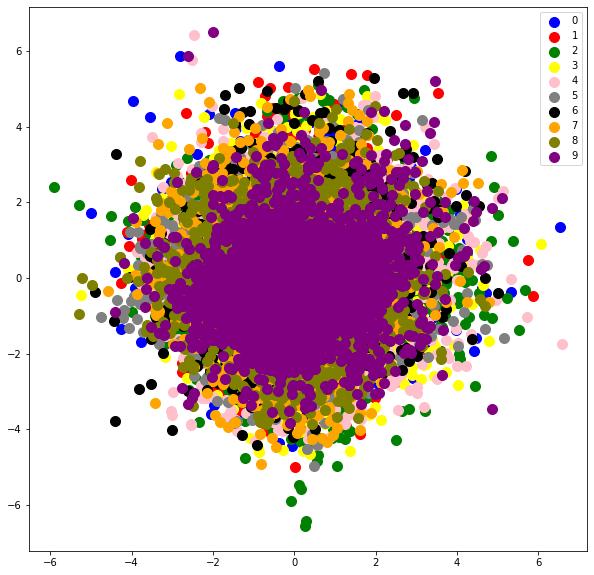

In [ ]:
plot_latent_space(latent_space_CVAE.T[0], latent_space_CVAE.T[1], targets_CVAE)

Drawing latent space images through two dimension with label 8...

As you see, 8 entered as one hot encoded condition and result is 8 with different orientation and loop size.

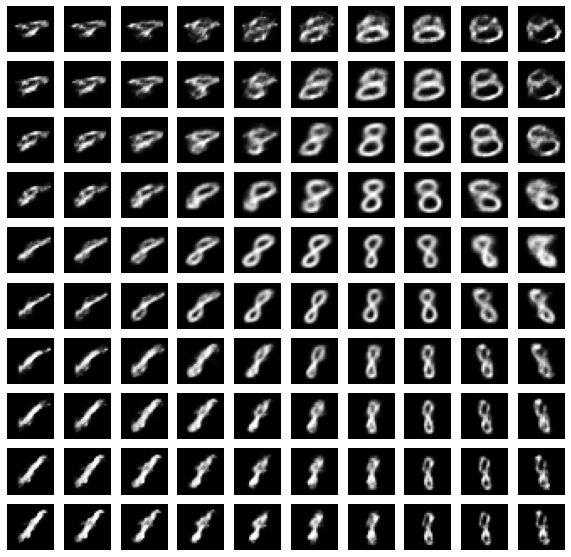

In [ ]:
min_x = latent_space_VAE.T[0].min()
max_x = latent_space_VAE.T[0].max()

min_y = latent_space_VAE.T[1].min()
max_y = latent_space_VAE.T[1].max()

x = np.arange(min_x, max_x, (max_x-min_x)/10)

y = np.arange(min_y, max_y, (max_y-min_y)/10)[::-1]

inp = []
for j in y:
  for i in x:
    inp.append(np.array([i, j]))

inp = torch.from_numpy(np.array(inp)).float().cuda()
cond_label = 8
selected_label = one_hot(torch.from_numpy(np.array([cond_label for i in range(len(inp))])), 10).cuda()
out = model_CVAE.decode(inp, selected_label)
show_numbers(out.cpu().data.numpy())

## Analayze CVAE output

We use previous indices to be able to compare it with `VAE`.

We show output of this model for previous samples.
You can more quality in output because of setting real labels as condition.

In [ ]:
random_index_CVAE = random_index_VAE.copy()

In [ ]:
random_inputs_CVAE = random_inputs_VAE.copy()
random_inputs_CVAE = torch.from_numpy(random_inputs_CVAE).cuda()
random_targets_CVAE = one_hot(torch.from_numpy(targets_VAE[random_index_CVAE]), 10).float()
random_targets_CVAE = random_targets_CVAE.cuda()
random_outputs_CVAE,_,_ = model_CVAE(random_inputs_CVAE, random_targets_CVAE)

In [ ]:
targets_VAE[random_index_CVAE]

array([4, 2, 5, 1, 3, 7, 5, 1, 3, 5, 8, 7, 5, 3, 3, 8, 5, 5, 8, 8, 8, 9,
       9, 1, 4, 1, 6, 0, 6, 8, 6, 8, 4, 6, 1, 9, 6, 5, 0, 8, 6, 8, 3, 0,
       2, 9, 7, 2, 0, 2])

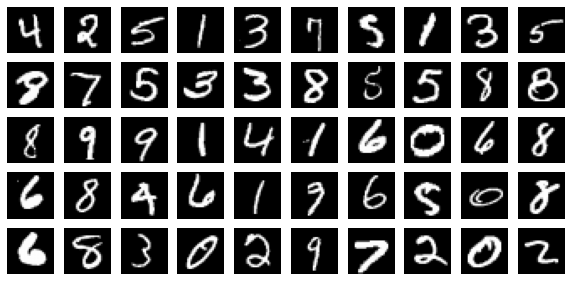

In [ ]:
show_numbers(random_inputs_CVAE.cpu().data.numpy())

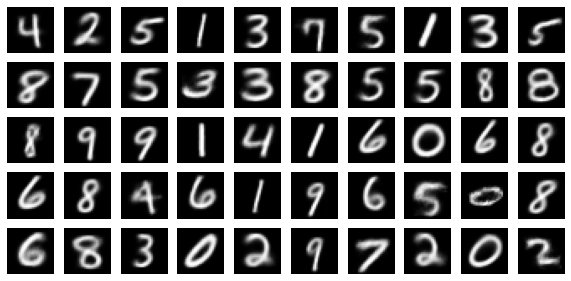

In [ ]:
show_numbers(random_outputs_CVAE.cpu().data.numpy())